In [29]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.


distutils: c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python310\Include\UNKNOWN
sysconfig: c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python310\Include
user = False
home = None
root = None
prefix = None
distutils: c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python310\Include\UNKNOWN
sysconfig: c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python310\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [30]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import importlib

from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

In [31]:
# show(filtered_df)
print(torch.cuda.is_available())
print("PyTorch version:", torch.__version__)
print("CUDA version in PyTorch:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

True
PyTorch version: 2.6.0+cu118
CUDA version in PyTorch: 11.8
Is CUDA available: True


In [32]:
import importlib
import sys

# Delete all submodules from sys.modules to force a full reload
submodules = [
    'MyPackage.embeddings',
    'MyPackage.process',
    'MyPackage.visualize',
    'MyPackage.markov',
    'MyPackage.testing',
    'MyPackage.sort_frame',
    
]

for submodule in submodules:
    if submodule in sys.modules:
        del sys.modules[submodule]

import MyPackage.process
import MyPackage.process_df
import MyPackage.visualize
import MyPackage.markov
import MyPackage.embeddings
import MyPackage.testing
import MyPackage.sort_frame

importlib.reload(MyPackage.process)
importlib.reload(MyPackage.process_df)
importlib.reload(MyPackage.visualize)
importlib.reload(MyPackage.markov)
importlib.reload(MyPackage.embeddings)
importlib.reload(MyPackage.testing)
importlib.reload(MyPackage.sort_frame)

from MyPackage.embeddings import *
from MyPackage.process import *
from MyPackage.process_df import *
from MyPackage.visualize import *
from MyPackage.markov import *
from MyPackage.testing import *
from MyPackage.sort_frame import *

print("All functions and classes have been reloaded and imported.")
from MyPackage.testing import benchmark3, benchmark4


[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]
[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]
All functions and classes have been reloaded and imported.


### Creating SQL Database Connection and Converting tables to dfs ###

In [33]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [34]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table


# merges climbs and climb stat tables, filters climbs df, adds additional features to data, sorts climb hold order using sorting function
# Filters: layout_id = 1, ascensionist_count >=1, hold_count <= 21, vgrade in range [0,15], is frame valid using is_frame_valid(), sort climb frame hold order 
# Added features = vgrade, hold_count
# All features = 'name','vgrade','angle_y','display_difficulty', 'ascensionist_count','frames', 'is_draft',  'climb_uuid', 'hold_count'
import pandas as pd

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = create_filtered_climbs_df(climbs, climb_stats,-1,-1)

print("Number of climbs:", filtered_df.shape[0])

#process each frame
filtered_df.apply(process_frame)

file_path = 'climbs.txt'
filtered_df_to_text_file(filtered_df, file_path= file_path)



Number of climbs: 98951


In [35]:

ids_to_coordinates()
print(len(filtered_df))

ID 1447 converted to coordinates: (34, 0)
ID 1448 converted to coordinates: (32, 0)
ID 1449 converted to coordinates: (30, 0)
ID 1450 converted to coordinates: (28, 0)
ID 1451 converted to coordinates: (26, 0)
ID 1452 converted to coordinates: (24, 0)
ID 1453 converted to coordinates: (22, 0)
ID 1454 converted to coordinates: (20, 0)
ID 1455 converted to coordinates: (18, 0)
ID 1456 converted to coordinates: (16, 0)
ID 1457 converted to coordinates: (14, 0)
ID 1458 converted to coordinates: (12, 0)
ID 1459 converted to coordinates: (10, 0)
ID 1460 converted to coordinates: (8, 0)
ID 1461 converted to coordinates: (6, 0)
ID 1462 converted to coordinates: (4, 0)
ID 1463 converted to coordinates: (2, 0)
ID 1464 converted to coordinates: (0, 0)
ID 1465 converted to coordinates: (0, 3)
ID 1466 converted to coordinates: (4, 3)
ID 1467 converted to coordinates: (8, 3)
ID 1468 converted to coordinates: (12, 3)
ID 1469 converted to coordinates: (16, 3)
ID 1470 converted to coordinates: (20, 3)


### Prepare Data into npz file ###

In [36]:
def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_index2 = id_to_index2(hold_ids[i])
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (int(y), int(x), int(val) , int(hold_index2), int(hold_val_class_id), hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

# Load the climb matrices
climb_matrices = load_npz('climb_matrices.npz')

# print random climbs name and its tuple list
climb_names = list(climb_matrices.keys())
random_climb_name = random.choice(climb_names)
random_climb_matrix = climb_matrices[random_climb_name]
print(f"Random climb name: {random_climb_name}")
print("Tuple list:")
for feature_tuple in random_climb_matrix:
    print(tuple(feature_tuple))

def hold_to_tuple(index2, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = index2_to_id(int(index2))
    hold_class_id = id_to_class_id(hold_id)
    x, y = id_to_coordinate(hold_id)

    val_class_id = val
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (int(y), int(x), int(val_class_id), int(index2), int(hold_val_class_id), hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple


[ 1.72688649e+01  1.70022747e+01  1.63373665e+00  2.40512690e+02
  9.02139370e+02 -3.44570578e-03  5.91691290e-01]
Random climb name: On Point
Tuple list:
(np.float64(12.0), np.float64(9.0), np.float64(0.0), np.float64(168.0), np.float64(424.0), np.float64(-0.057458870465772895), np.float64(0.7))
(np.float64(30.0), np.float64(31.0), np.float64(3.0), np.float64(414.0), np.float64(1867.0), np.float64(-0.431100712017389), np.float64(0.7))
(np.float64(18.0), np.float64(5.0), np.float64(0.0), np.float64(244.0), np.float64(620.0), np.float64(-0.7779411802037216), np.float64(0.8))
(np.float64(11.0), np.float64(0.0), np.float64(3.0), np.float64(155.0), np.float64(1511.0), np.float64(0.7071067811865476), np.float64(0.2))
(np.float64(20.0), np.float64(9.0), np.float64(1.0), np.float64(272.0), np.float64(697.0), np.float64(-0.7690393009359403), np.float64(0.8))
(np.float64(22.0), np.float64(19.0), np.float64(1.0), np.float64(303.0), np.float64(785.0), np.float64(0.3696674488767354), np.float64(0.

### RNN Model ###

Train and Val Datasets Created
Sequence Train and Val Datasets Created
Train Dataset Size: 306418
Validation Dataset Size: 87438
Test Dataset Size: 4000
Train and Val Loaders Created
Validation Loss: 10.2319, Validation Row Accuracy: 0.2813, Validation Col Accuracy: 0.1297, Validation Hold Class Accuracy: 0.0610, Validation Val Accuracy: 0.6901, Average Validation Expected Euclidean Distance (EED): 0.0000
Validation Loss: 10.0252, Validation Row Accuracy: 0.2880, Validation Col Accuracy: 0.1419, Validation Hold Class Accuracy: 0.0699, Validation Val Accuracy: 0.7014, Average Validation Expected Euclidean Distance (EED): 0.0000
Validation Loss: 9.9287, Validation Row Accuracy: 0.2900, Validation Col Accuracy: 0.1420, Validation Hold Class Accuracy: 0.0740, Validation Val Accuracy: 0.7012, Average Validation Expected Euclidean Distance (EED): 0.0000


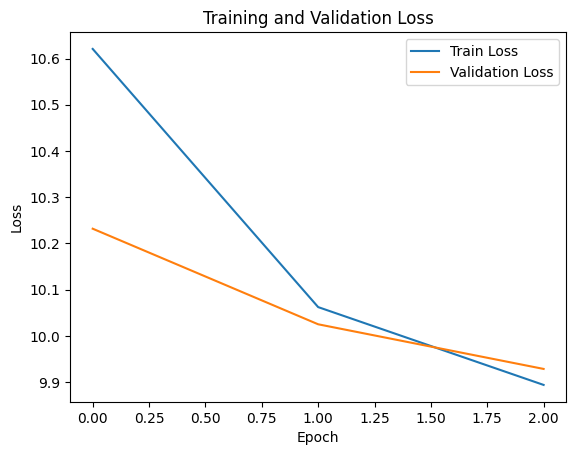

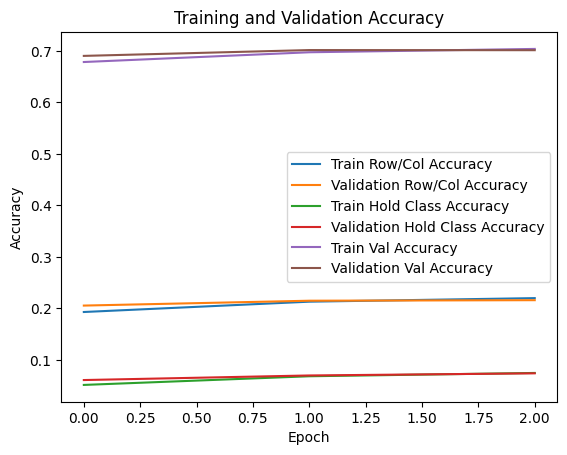

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        row_labels = climb_matrix[:, 0].astype(int)
        col_labels = climb_matrix[:, 1].astype(int)
        hold_class_labels = climb_matrix[:, 3].astype(int)
        val_labels = climb_matrix[:, 2].astype(int)
        return climb_matrix, row_labels, col_labels, hold_class_labels, val_labels

class SequenceDataset(Dataset):
    def __init__(self, dataset):
        self.sequences, self.row_labels, self.col_labels, self.hold_class_labels, self.val_labels = self.extract_sequences(dataset)

    def extract_sequences(self, dataset):
        sequences = []
        row_labels = []
        col_labels = []
        hold_class_labels = []
        val_labels = []

        for i in range(len(dataset)):
            climb_matrix, row_ids, col_ids, hold_class_ids, vals = dataset[i]
            for j in range(1, len(climb_matrix)):
                sequence = climb_matrix[:j]
                row_label = row_ids[j]
                col_label = col_ids[j]
                hold_class_label = hold_class_ids[j]
                val_label = vals[j]
                sequences.append(sequence)
                row_labels.append(row_label)
                col_labels.append(col_label)
                hold_class_labels.append(hold_class_label)
                val_labels.append(val_label)
        return sequences, row_labels, col_labels, hold_class_labels, val_labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        row_label = self.row_labels[idx]
        col_label = self.col_labels[idx]
        hold_class_label = self.hold_class_labels[idx]
        val_label = self.val_labels[idx]
        return sequence, row_label, col_label, hold_class_label, val_label


class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layers
        self.fc_row = nn.Linear(hidden_size, 35)  # Predict 35 values for row
        self.fc_col = nn.Linear(hidden_size, 35)  # Predict 35 values for col
        self.fc_hold_class = nn.Linear(hidden_size, 476)  # Predict 476 values for hold class
        self.fc_val = nn.Linear(hidden_size, 4)  # Predict 4 values for val

        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_row.weight)
        init.constant_(self.fc_row.bias, 0)
        
        init.xavier_uniform_(self.fc_col.weight)
        init.constant_(self.fc_col.bias, 0)

        init.xavier_uniform_(self.fc_hold_class.weight)
        init.constant_(self.fc_hold_class.bias, 0)

        init.xavier_uniform_(self.fc_val.weight)
        init.constant_(self.fc_val.bias, 0)
        
    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        row_pred = self.fc_row(out)
        col_pred = self.fc_col(out)
        hold_class_pred = self.fc_hold_class(out)
        val_pred = self.fc_val(out)
        
        return row_pred, col_pred, hold_class_pred, val_pred, hn, cn

def collate_fn(batch):
    sequences = [seq for seq, _, _, _, _ in batch]
    row_labels = torch.tensor([row_label for _, row_label, _, _, _ in batch], dtype=torch.long)
    col_labels = torch.tensor([col_label for _, _, col_label, _, _ in batch], dtype=torch.long)
    hold_class_labels = torch.tensor([hold_class_label for _, _, _, hold_class_label, _ in batch], dtype=torch.long)
    val_labels = torch.tensor([val_label for _, _, _, _, val_label in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels

# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create sequence datasets for train and validation
sequence_train_dataset = SequenceDataset(train_dataset)
sequence_val_dataset = SequenceDataset(val_dataset)
print("Sequence Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(sequence_train_dataset)}")
print(f"Validation Dataset Size: {len(sequence_val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for sequence datasets
train_loader = DataLoader(sequence_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(sequence_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Number of epochs
num_epochs =3

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_hold_class_accuracies = []
val_hold_class_accuracies = []
train_val_accuracies = []
val_val_accuracies = []

# Define loss functions
criterion_row = nn.CrossEntropyLoss()
criterion_col = nn.CrossEntropyLoss()
criterion_hold_class = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_row_preds = 0
    correct_col_preds = 0
    correct_hold_class_preds = 0
    correct_val_preds = 0
    total_train_preds = 0
    
    for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels in train_loader:

        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)
        row_labels = row_labels.to(device)
        col_labels = col_labels.to(device)
        hold_class_labels = hold_class_labels.to(device)
        val_labels = val_labels.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        row_pred, col_pred, hold_class_pred, val_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute row, col, hold class, and val loss
        row_loss = criterion_row(row_pred, row_labels)
        col_loss = criterion_col(col_pred, col_labels)
        hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)
        val_loss = criterion_val(val_pred, val_labels)

        # Combine losses
        batch_loss = row_loss + col_loss + hold_class_loss + val_loss

        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
        correct_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
        correct_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
        correct_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
        total_train_preds += row_labels.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_row_accuracy = correct_row_preds / total_train_preds
    train_col_accuracy = correct_col_preds / total_train_preds
    train_hold_class_accuracy = correct_hold_class_preds / total_train_preds
    train_val_accuracy = correct_val_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append((train_row_accuracy + train_col_accuracy) / 2)
    train_hold_class_accuracies.append(train_hold_class_accuracy)
    train_val_accuracies.append(train_val_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_row_preds = 0
    correct_val_col_preds = 0
    correct_val_hold_class_preds = 0
    correct_val_val_preds = 0
    total_val_preds = 0
    total_val_eed = 0.0
    with torch.no_grad():
        for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels in val_loader:

            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)
            row_labels = row_labels.to(device)
            col_labels = col_labels.to(device)
            hold_class_labels = hold_class_labels.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            row_pred, col_pred, hold_class_pred, val_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute row, col, hold class, and val loss
            row_loss = criterion_row(row_pred, row_labels)
            col_loss = criterion_col(col_pred, col_labels)
            hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)

            val_loss = criterion_val(val_pred, val_labels)

            # Total loss
            batch_loss = row_loss + col_loss + hold_class_loss + val_loss
            running_val_loss += batch_loss.item()

            # Calculate validation accuracy
            correct_val_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
            correct_val_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
            correct_val_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
            correct_val_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
            total_val_preds += row_labels.size(0)

    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)

    avg_val_eed = total_val_eed / len(val_loader)

    val_row_accuracy = correct_val_row_preds / total_val_preds
    val_col_accuracy = correct_val_col_preds / total_val_preds
    val_hold_class_accuracy = correct_val_hold_class_preds / total_val_preds
    val_val_accuracy = correct_val_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append((val_row_accuracy + val_col_accuracy) / 2)
    val_hold_class_accuracies.append(val_hold_class_accuracy)
    val_val_accuracies.append(val_val_accuracy)
    
    # Print epoch statistics
    print(f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Row Accuracy: {val_row_accuracy:.4f}, Validation Col Accuracy: {val_col_accuracy:.4f}, "
          f"Validation Hold Class Accuracy: {val_hold_class_accuracy:.4f}, Validation Val Accuracy: {val_val_accuracy:.4f}, "
          f"Average Validation Expected Euclidean Distance (EED): {avg_val_eed:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Row/Col Accuracy')
plt.plot(val_accuracies, label='Validation Row/Col Accuracy')
plt.plot(train_hold_class_accuracies, label='Train Hold Class Accuracy')
plt.plot(val_hold_class_accuracies, label='Validation Hold Class Accuracy')
plt.plot(train_val_accuracies, label='Train Val Accuracy')
plt.plot(val_val_accuracies, label='Validation Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [38]:
# Save the model's state dictionary
# torch.save(model.state_dict(), 'RNN_13_Multitask_Final_Model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN().to(device)

# # Load the model's state dictionary
model.load_state_dict(torch.load('RNN_13_Multitask_Final_Model.pth'))

<All keys matched successfully>

### Generate RNN Climb ###

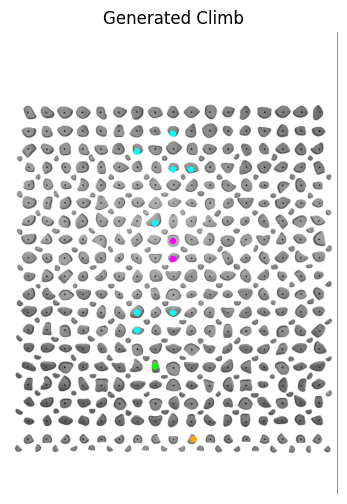

In [39]:
import torch.nn.functional as F
import random
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the range of k values
k_values = np.arange(8,30)

# Define the mean (median) and standard deviation
mean_k = 12
std_k = 1.5

# Generate a truncated normal distribution within the range [1, 10]
a, b = (8 - mean_k) / std_k, (30 - mean_k) / std_k
trunc_norm = truncnorm(a, b, loc=mean_k, scale=std_k)

# Calculate the probability distribution for k_values
k_probabilities = trunc_norm.pdf(k_values)

# Normalize to ensure the probabilities sum to 1
k_probabilities /= k_probabilities.sum()

import torch.nn.functional as F
import random
from scipy.stats import truncnorm
import numpy as np
import math

# Define the range of k values
k_values = np.arange(8, 30)

# Define the mean and standard deviation
mean_k = 12
std_k = 1.5

# Generate a truncated normal distribution within the range [8, 30]
a, b = (8 - mean_k) / std_k, (30 - mean_k) / std_k
trunc_norm = truncnorm(a, b, loc=mean_k, scale=std_k)

# Calculate the probability distribution for k_values
k_probabilities = trunc_norm.pdf(k_values)

# Normalize to ensure the probabilities sum to 1
k_probabilities /= k_probabilities.sum()

def generate_climb_from_sequence(initial_holds, initial_vals, num_holds, max_retries=5):
    while True:
        model.eval()
        
        generated_hold_ids = initial_holds.copy()
        generated_vals = initial_vals.copy()

        # Convert initial holds and values to the corresponding tuples and tensors
        initial_tuples = [hold_to_tuple(id_to_index2(hold_id), val) for hold_id, val in zip(initial_holds, initial_vals)]
        current_sequence = torch.tensor(initial_tuples, dtype=torch.float).unsqueeze(0).to(device)

        # Initialize hidden states
        h0, c0 = None, None
        
        max_attempts = 10  # Maximum number of attempts to find a unique hold

        with torch.no_grad():
            for step in range(num_holds - len(initial_holds)):
                lengths = torch.tensor([current_sequence.size(1)], dtype=torch.int64).to(device)

                row_logits, col_logits, hold_class_logits, val_class_logits, h0, c0 = model(current_sequence, lengths, h0, c0)
                
                # Apply softmax to convert logits to probabilities
                hold_class_prob = F.softmax(hold_class_logits, dim=1)

                # Sample the next hold_val_class_id from the probability distribution
                val_class = torch.argmax(val_class_logits, dim=1).item()

                # Select k from the truncated normal distribution
                k = int(np.random.choice(k_values, p=k_probabilities))
                k_current = k  # Initialize current k

                # Define maximum k to prevent it from exceeding the total number of holds
                k_max = hold_class_prob.size(1)

                topk_hold_values, topk_hold_indices = torch.topk(hold_class_prob, k_current)
                topk_hold_indices = topk_hold_indices.squeeze().tolist()

                # Ensure topk_hold_indices is a list
                if isinstance(topk_hold_indices, int):
                    topk_hold_indices = [topk_hold_indices]

                # Randomly select a hold from the top-k
                hold_class_id = random.choice(topk_hold_indices)

                attempts = 0
                while index2_to_id(hold_class_id) in generated_hold_ids and attempts < max_attempts:
                    hold_class_id = random.choice(topk_hold_indices)
                    attempts += 1

                # If max_attempts are reached, increase k_current and retry
                while attempts >= max_attempts and k_current < k_max:
                    k_current = min(k_current + 5, k_max)  # Increment k by 5, cap at k_max
                    
                    topk_hold_values, topk_hold_indices = torch.topk(hold_class_prob, k_current)
                    topk_hold_indices = topk_hold_indices.squeeze().tolist()
                    
                    # Ensure topk_hold_indices is a list
                    if isinstance(topk_hold_indices, int):
                        topk_hold_indices = [topk_hold_indices]
                    
                    hold_class_id = random.choice(topk_hold_indices)
                    attempts = 0
                    while index2_to_id(hold_class_id) in generated_hold_ids and attempts < max_attempts:
                        hold_class_id = random.choice(topk_hold_indices)
                        attempts += 1

                # Final check after increasing k
                if index2_to_id(hold_class_id) in generated_hold_ids:
                    # Option 1: Allow repetition
                    # generated_hold_ids.append(index2_to_id(hold_class_id))
                    # generated_vals.append(val_class)

                    # Option 2: Skip adding this hold
                    break  # Exit the for-loop and retry the entire sequence

                generated_hold_ids.append(index2_to_id(hold_class_id))
                generated_vals.append(val_class)

                # Prepare the next input
                next_tuple = hold_to_tuple(hold_class_id, val_class)
                next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
                
                # Concatenate next_tensor along the sequence dimension (dim=1)
                current_sequence = torch.cat((current_sequence, next_tensor), dim=1)
        
        # Validate the generated sequence
        start_hold_count = generated_vals.count(0)
        finish_hold_count = generated_vals.count(2)
        generated_hold_class_ids = [id_to_class_id(hold_id) for hold_id in initial_holds]
        
        # Check if the generated sequence meets the criteria
        if 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2:
            return generated_hold_ids, generated_vals, generated_hold_class_ids


def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        # id_2-=2
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

# def plot_distributions(row_class_prob, col_class_prob):
#     # Convert tensors to numpy arrays for plotting
#     row_class_prob_np = row_class_prob.squeeze().cpu().numpy()
#     col_class_prob_np = col_class_prob.squeeze().cpu().numpy()

#     # Plot the row class probabilities
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 2, 1)
#     plt.bar(range(len(row_class_prob_np)), row_class_prob_np)
#     plt.xlabel('Row Class Index')
#     plt.ylabel('Probability')
#     plt.title('Row Class Probabilities')

#     # Plot the col class probabilities
#     plt.subplot(1, 2, 2)
#     plt.bar(range(len(col_class_prob_np)), col_class_prob_np)
#     plt.xlabel('Column Class Index')
#     plt.ylabel('Probability')
#     plt.title('Column Class Probabilities')

#     plt.tight_layout()
#     plt.show()

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

# hold_ids, vals = generate_climb(model, 1081, 3, 12)

# initial_holds = [1081,1077]
# initial_vals = [3,3]  
# hold_ids, vals = generate_climb_from_sequence(model, initial_holds, initial_vals, 12)
# climb_to_image(hold_ids, vals) 

def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
        
        # Convert the frame to IDs
        ids_list_1, ids_list_2 = frame_to_ids(random_frame)

        # Initialize lists to store predictions
        predicted_hold_ids = []
        predicted_vals = []
        
        # Iterate through each ID and predict the next hold
        initial_holds = ids_list_1[:1] 
        initial_vals = ids_list_2[:1]  

        for i in range(1, len(ids_list_1)):
            hold_ids, vals, hold_class_ids = generate_climb_from_sequence(initial_holds, initial_vals, len(initial_holds) + 1)
            predicted_hold_ids.append(hold_ids[-1])
            predicted_vals.append(vals[-1])
            print(f"Actual Hold: {ids_list_1[i]} Predicted Hold: {hold_ids[-1]}, Actual Hold Class: {id_to_index2(ids_list_1[i])}, Predicted Hold Class: {id_to_index2(hold_ids[-1])}")
            initial_holds.append(ids_list_1[i])
            initial_vals.append(ids_list_2[i])
        
        # Calculate accuracy
        correct_predictions = sum(1 for i in range(2, len(ids_list_1)) if ids_list_1[i] == predicted_hold_ids[i-2])
        accuracy = correct_predictions / (len(ids_list_1) - 2)
        print(f"Prediction Accuracy: {accuracy:.2f}")
        # Create the image for the predicted holds
        climb_to_image(predicted_hold_ids, predicted_vals)
    else:
        print("The DataFrame is empty.")

# Example usage:
# Assuming you have a DataFrame `filtered_df` and a trained model `model`
# create_random_climb_image(filtered_df)

# predicted_hold_ids, predicted_vals, generated_hold_class_ids = generate_climb_from_sequence([1447], [3], 10)
predicted_hold_ids, predicted_vals, generated_hold_class_ids = generate_climb_from_sequence([index2_to_id(random.randint(0, 100))], [3], 12)

# generated_frame = hold_id_and_val_to_frame(predicted_hold_ids, predicted_vals)
# print("Benchmark: ", benchmark3(generated_frame, row_weight=0.1))
# benchmark_value = custom_benchmark(model=model,  device=device, n=500, num_holds=12, k_percent=50)
# print(benchmark_value)
climb_to_image(predicted_hold_ids, predicted_vals)



In [40]:
# show(filtered_df)
print(torch.cuda.is_available())
print("PyTorch version:", torch.__version__)
print("CUDA version in PyTorch:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

True
PyTorch version: 2.6.0+cu118
CUDA version in PyTorch: 11.8
Is CUDA available: True
